## I. Introduction

## II. Model Building - Reinforcement Learning

### 1. Coding Environment

In [1]:
# pytorch install
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [2]:
# install PyQt5
!pip install PyQt5

In [3]:
# install WebEngine
!pip install PyQtWebEngine

In [4]:
#install stable baseline3
!pip install stable-baselines3[extra] protobuf==3.20.*

In [5]:
!pip install mss pydirectinput pytesseract

In [6]:
!pip install Pillow

In [7]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
ale-py                        0.7.4
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
anytree                       2.8.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
AutoROM                       0.6.1
AutoROM.accept-rom-license    0.6.1
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backp

Skip installation if your workingspace is already satisfied

In [1]:
from mss import mss # screen shot
import pydirectinput # Sending commands to control the dino
import cv2 # Open CV frame processing
import numpy as np # calculation
import pytesseract # OCR to detect when game is over
from matplotlib import pyplot as plt # Visulization
import time # Track time and perform pauses
from gym import Env # Environment components
from gym.spaces import Box, Discrete
pytesseract.pytesseract.tesseract_cmd = r'E:\tesseract\tesseract.exe'

### 2. Build Coding Environment

#### 2.1. Create the Environment

In [2]:
class DinoGame(Env):
    def __init__(self): # setup the environment action and observation shapes
        # this is a subclass model
        super().__init__()
        # set up blank canvas for observation spaces we want
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8) # initialization of the canvas
        self.action_space = Discrete(3) # three action agent could do in this game
        
        # Use mss as our screen capture parameter
        self.cap = mss()
        
        # Two oberservation space we focused on
        self.game_location = {"top":500, "left": 0, "width": 800, "height": 600} # 27 inches monitors
        #self.game_location = {"top":400, "left": 0, "width": 600, "height": 400} # 17.3 inches laptop screen
        self.done_location = {"top":550, "left": 830, "width": 900, "height": 100} # 27 inches monitors
        #self.done_location = {"top":375, "left": 630, "width": 650, "height": 100} # 17.3 inches laptop screen

    def gamespace(self): # get a part of the screen from the game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8) # Raw Game area
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)# Grayscaled Game area
        channel = np.reshape(cv2.resize(gray, (100,83)), (1,83,100)) # reshape into pytorch and stablebaseline format channel
        return channel
    
    def gameover(self): # Check if game is over
        pic = np.array(self.cap.grab(self.done_location))[:,:,:3].astype(np.uint8)
        done_strings = ['G']
        done=False
        text = pytesseract.image_to_string(pic)[:1] # OCR image to word converter
        if text in done_strings:
            done = True
        return done, pic, text
    
    def step(self, action): # call an action
        # Key-Action: Space-Jump, 1-Duck, 2-No action
        action_map = {
            0: "space",
            1: "down",
            2: "no_op"
        }
        if action != 2: # Press a key if we need an action
            pydirectinput.press(action_map[action])
            
        done, pic, text = self.gameover() # Check if game is over
        new_observation = self.gamespace() # Get a new dino pic
        
        #Reward system
        
        #reward = 1 # one point for each frame being alive
        
        if not done:
            reward = 1
        else:
            reward = -5
            
        info = {}
        return new_observation, reward, done, info
    
    def render(self): # Visulization
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) and 0xFF == ord('q'):
            self.close()
    
    def reset(self): # reset the game when die
        time.sleep(1)
        pydirectinput.click(x=200, y=200)
        pydirectinput.press("space")
        return self.gamespace()
    
    def close(self): # close the observation
        cv2.destroyAllWindows()
    

#### 2.2. Test the Environment

In [3]:
env = DinoGame()

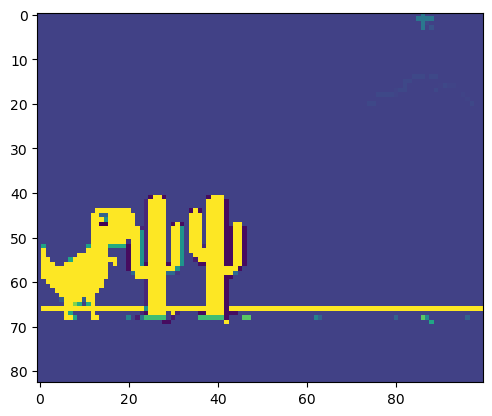

In [7]:
plt.imshow(cv2.cvtColor(env.gamespace()[0], cv2.COLOR_BGR2RGB))
plt.imshow(env.gamespace()[0])

True

'G'

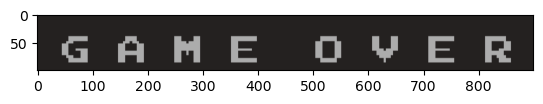

In [5]:
done, pic, text = env.gameover()
display(done)
display(text)
plt.imshow(pic)

In [39]:
for episode in range(5): # Play 10 games
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f"Total Reward for episode {episode+1} is {total_reward}")

Total Reward for episode 1 is -1
Total Reward for episode 2 is 7
Total Reward for episode 3 is 7
Total Reward for episode 4 is 6
Total Reward for episode 5 is 5


### 3. Train the Model

#### 3.1. Create Callback

In [4]:
# import more packages
import os # for file path
from stable_baselines3.common.callbacks import BaseCallback # for saving models
from stable_baselines3.common import env_checker # check environment

In [8]:
env_checker.check_env(env)

In [5]:
class TrainAndLoggingCallback(BaseCallback): # Completely from online (Nicholas Renotte)

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [6]:
checkpoint_dir = "./train/new_rew_sys"
log_dir = "./logs/"

In [7]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path = checkpoint_dir)

#### 3.2. Build DQN Model and Train

In [8]:
from stable_baselines3 import DQN # DQN algorithm

In [9]:
model = DQN("CnnPolicy", 
            env, 
            tensorboard_log=log_dir,
            verbose=1, 
            buffer_size=420000, 
            learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [48]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/DQN_8
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 7.5      |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 27       |
|    total_timesteps  | 54       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 7        |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 53       |
|    total_timesteps  | 104      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.2     |
|    ep_rew_mean      | 7.17     |
|    exploration_rate | 0.985    |
| time/               |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 7.48     |
|    exploration_rate | 0.887    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 2        |
|    time_elapsed     | 586      |
|    total_timesteps  | 1186     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 46       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 7.5      |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 2        |
|    time_elapsed     | 612      |
|    total_timesteps  | 1242     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.9     |
|    ep_rew_mean      | 7.89     |
|    exploration_rate | 0.801    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 2        |
|    time_elapsed     | 1016     |
|    total_timesteps  | 2098     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 274      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.9     |
|    ep_rew_mean      | 7.9      |
|    exploration_rate | 0.795    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 2        |
|    time_elapsed     | 1043     |
|    total_timesteps  | 2156     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.163    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.6     |
|    ep_rew_mean      | 7.58     |
|    exploration_rate | 0.718    |
| time/               |          |
|    episodes         | 216      |
|    fps              | 2        |
|    time_elapsed     | 1442     |
|    total_timesteps  | 2968     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.127    |
|    n_updates        | 491      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 7.53     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 2        |
|    time_elapsed     | 1467     |
|    total_timesteps  | 3023     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0162   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.9     |
|    ep_rew_mean      | 7.95     |
|    exploration_rate | 0.632    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 2        |
|    time_elapsed     | 1877     |
|    total_timesteps  | 3873     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 718      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 7.79     |
|    exploration_rate | 0.627    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 2        |
|    time_elapsed     | 1903     |
|    total_timesteps  | 3926     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.157    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14       |
|    ep_rew_mean      | 8.01     |
|    exploration_rate | 0.549    |
| time/               |          |
|    episodes         | 344      |
|    fps              | 2        |
|    time_elapsed     | 2294     |
|    total_timesteps  | 4750     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.272    |
|    n_updates        | 937      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 8.1      |
|    exploration_rate | 0.543    |
| time/               |          |
|    episodes         | 348      |
|    fps              | 2        |
|    time_elapsed     | 2323     |
|    total_timesteps  | 4811     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0235   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.9     |
|    ep_rew_mean      | 7.94     |
|    exploration_rate | 0.464    |
| time/               |          |
|    episodes         | 408      |
|    fps              | 2        |
|    time_elapsed     | 2714     |
|    total_timesteps  | 5645     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0152   |
|    n_updates        | 1161     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 7.85     |
|    exploration_rate | 0.459    |
| time/               |          |
|    episodes         | 412      |
|    fps              | 2        |
|    time_elapsed     | 2740     |
|    total_timesteps  | 5699     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0242   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 7.7      |
|    exploration_rate | 0.381    |
| time/               |          |
|    episodes         | 472      |
|    fps              | 2        |
|    time_elapsed     | 3133     |
|    total_timesteps  | 6516     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0112   |
|    n_updates        | 1378     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.9     |
|    ep_rew_mean      | 7.91     |
|    exploration_rate | 0.374    |
| time/               |          |
|    episodes         | 476      |
|    fps              | 2        |
|    time_elapsed     | 3165     |
|    total_timesteps  | 6586     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.152    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.9     |
|    ep_rew_mean      | 7.91     |
|    exploration_rate | 0.295    |
| time/               |          |
|    episodes         | 536      |
|    fps              | 2        |
|    time_elapsed     | 3563     |
|    total_timesteps  | 7422     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0333   |
|    n_updates        | 1605     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14       |
|    ep_rew_mean      | 8        |
|    exploration_rate | 0.289    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 2        |
|    time_elapsed     | 3590     |
|    total_timesteps  | 7487     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.138    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14       |
|    ep_rew_mean      | 7.98     |
|    exploration_rate | 0.209    |
| time/               |          |
|    episodes         | 600      |
|    fps              | 2        |
|    time_elapsed     | 3986     |
|    total_timesteps  | 8325     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00447  |
|    n_updates        | 1831     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 8.13     |
|    exploration_rate | 0.203    |
| time/               |          |
|    episodes         | 604      |
|    fps              | 2        |
|    time_elapsed     | 4013     |
|    total_timesteps  | 8392     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00934  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.2     |
|    ep_rew_mean      | 8.15     |
|    exploration_rate | 0.123    |
| time/               |          |
|    episodes         | 664      |
|    fps              | 2        |
|    time_elapsed     | 4403     |
|    total_timesteps  | 9227     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.024    |
|    n_updates        | 2056     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 8.05     |
|    exploration_rate | 0.119    |
| time/               |          |
|    episodes         | 668      |
|    fps              | 2        |
|    time_elapsed     | 4428     |
|    total_timesteps  | 9274     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0214   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14       |
|    ep_rew_mean      | 8.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 728      |
|    fps              | 2        |
|    time_elapsed     | 4825     |
|    total_timesteps  | 10133    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.311    |
|    n_updates        | 2283     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.3     |
|    ep_rew_mean      | 8.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 732      |
|    fps              | 2        |
|    time_elapsed     | 4858     |
|    total_timesteps  | 10211    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.2     |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 792      |
|    fps              | 2        |
|    time_elapsed     | 5357     |
|    total_timesteps  | 11437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.355    |
|    n_updates        | 2609     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.7     |
|    ep_rew_mean      | 12.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 796      |
|    fps              | 2        |
|    time_elapsed     | 5397     |
|    total_timesteps  | 11539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.064    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.8     |
|    ep_rew_mean      | 15.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 856      |
|    fps              | 2        |
|    time_elapsed     | 5916     |
|    total_timesteps  | 12817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 2954     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.7     |
|    ep_rew_mean      | 15.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 860      |
|    fps              | 2        |
|    time_elapsed     | 5955     |
|    total_timesteps  | 12913    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0114   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.3     |
|    ep_rew_mean      | 17.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 920      |
|    fps              | 2        |
|    time_elapsed     | 6504     |
|    total_timesteps  | 14337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0942   |
|    n_updates        | 3334     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 924      |
|    fps              | 2        |
|    time_elapsed     | 6545     |
|    total_timesteps  | 14456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.253    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.2     |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 984      |
|    fps              | 2        |
|    time_elapsed     | 7086     |
|    total_timesteps  | 15791    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 3697     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 988      |
|    fps              | 2        |
|    time_elapsed     | 7128     |
|    total_timesteps  | 15900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0261   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.7     |
|    ep_rew_mean      | 15.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1048     |
|    fps              | 2        |
|    time_elapsed     | 7665     |
|    total_timesteps  | 17201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.334    |
|    n_updates        | 4050     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 15.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1052     |
|    fps              | 2        |
|    time_elapsed     | 7697     |
|    total_timesteps  | 17264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0163   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1112     |
|    fps              | 2        |
|    time_elapsed     | 8277     |
|    total_timesteps  | 18690    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 4422     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.7     |
|    ep_rew_mean      | 16.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1116     |
|    fps              | 2        |
|    time_elapsed     | 8308     |
|    total_timesteps  | 18755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0243   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.9     |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1176     |
|    fps              | 2        |
|    time_elapsed     | 8852     |
|    total_timesteps  | 20104    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.265    |
|    n_updates        | 4775     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.8     |
|    ep_rew_mean      | 15.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 2        |
|    time_elapsed     | 8885     |
|    total_timesteps  | 20184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.9     |
|    ep_rew_mean      | 16.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 2        |
|    time_elapsed     | 9413     |
|    total_timesteps  | 21617    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0725   |
|    n_updates        | 5154     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.9     |
|    ep_rew_mean      | 16.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1244     |
|    fps              | 2        |
|    time_elapsed     | 9447     |
|    total_timesteps  | 21722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0648   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27       |
|    ep_rew_mean      | 21       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 2        |
|    time_elapsed     | 10057    |
|    total_timesteps  | 23478    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0409   |
|    n_updates        | 5619     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.4     |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1308     |
|    fps              | 2        |
|    time_elapsed     | 10108    |
|    total_timesteps  | 23610    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.9     |
|    ep_rew_mean      | 19.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1368     |
|    fps              | 2        |
|    time_elapsed     | 10653    |
|    total_timesteps  | 25124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0314   |
|    n_updates        | 6030     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.3     |
|    ep_rew_mean      | 20.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1372     |
|    fps              | 2        |
|    time_elapsed     | 10695    |
|    total_timesteps  | 25255    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.247    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | 22.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1432     |
|    fps              | 2        |
|    time_elapsed     | 11292    |
|    total_timesteps  | 26969    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.287    |
|    n_updates        | 6492     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 2        |
|    time_elapsed     | 11329    |
|    total_timesteps  | 27086    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0217   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.3     |
|    ep_rew_mean      | 22.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1496     |
|    fps              | 2        |
|    time_elapsed     | 11936    |
|    total_timesteps  | 28763    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 6940     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.3     |
|    ep_rew_mean      | 21.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 2        |
|    time_elapsed     | 11965    |
|    total_timesteps  | 28824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0349   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.1     |
|    ep_rew_mean      | 21.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 2        |
|    time_elapsed     | 12528    |
|    total_timesteps  | 30428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0959   |
|    n_updates        | 7356     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.5     |
|    ep_rew_mean      | 20.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1564     |
|    fps              | 2        |
|    time_elapsed     | 12569    |
|    total_timesteps  | 30549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0275   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.1     |
|    ep_rew_mean      | 20.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1624     |
|    fps              | 2        |
|    time_elapsed     | 13147    |
|    total_timesteps  | 32133    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0367   |
|    n_updates        | 7783     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.5     |
|    ep_rew_mean      | 20.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1628     |
|    fps              | 2        |
|    time_elapsed     | 13186    |
|    total_timesteps  | 32252    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.2     |
|    ep_rew_mean      | 19.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1688     |
|    fps              | 2        |
|    time_elapsed     | 13736    |
|    total_timesteps  | 33725    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.238    |
|    n_updates        | 8181     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.5     |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1692     |
|    fps              | 2        |
|    time_elapsed     | 13766    |
|    total_timesteps  | 33794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.089    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.8     |
|    ep_rew_mean      | 18.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1752     |
|    fps              | 2        |
|    time_elapsed     | 14326    |
|    total_timesteps  | 35372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 8592     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.3     |
|    ep_rew_mean      | 19.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 2        |
|    time_elapsed     | 14373    |
|    total_timesteps  | 35500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.7     |
|    ep_rew_mean      | 21.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1816     |
|    fps              | 2        |
|    time_elapsed     | 14975    |
|    total_timesteps  | 37233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 9058     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.5     |
|    ep_rew_mean      | 21.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 2        |
|    time_elapsed     | 15012    |
|    total_timesteps  | 37347    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.114    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.2     |
|    ep_rew_mean      | 23.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 2        |
|    time_elapsed     | 15637    |
|    total_timesteps  | 39178    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 9544     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | 22.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1884     |
|    fps              | 2        |
|    time_elapsed     | 15679    |
|    total_timesteps  | 39294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.4     |
|    ep_rew_mean      | 20.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 2        |
|    time_elapsed     | 16217    |
|    total_timesteps  | 40816    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 9953     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.5     |
|    ep_rew_mean      | 20.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1948     |
|    fps              | 2        |
|    time_elapsed     | 16252    |
|    total_timesteps  | 40929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.2     |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2008     |
|    fps              | 2        |
|    time_elapsed     | 16792    |
|    total_timesteps  | 42290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0363   |
|    n_updates        | 10322    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.9     |
|    ep_rew_mean      | 16.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2012     |
|    fps              | 2        |
|    time_elapsed     | 16817    |
|    total_timesteps  | 42335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0106   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.7     |
|    ep_rew_mean      | 16.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2072     |
|    fps              | 2        |
|    time_elapsed     | 17336    |
|    total_timesteps  | 43666    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.214    |
|    n_updates        | 10666    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.5     |
|    ep_rew_mean      | 16.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2076     |
|    fps              | 2        |
|    time_elapsed     | 17368    |
|    total_timesteps  | 43746    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.13     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 16.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2136     |
|    fps              | 2        |
|    time_elapsed     | 17883    |
|    total_timesteps  | 45051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 11012    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 2        |
|    time_elapsed     | 17925    |
|    total_timesteps  | 45168    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.294    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 2        |
|    time_elapsed     | 18502    |
|    total_timesteps  | 46667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 11416    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.2     |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 2        |
|    time_elapsed     | 18532    |
|    total_timesteps  | 46734    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.339    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2264     |
|    fps              | 2        |
|    time_elapsed     | 19079    |
|    total_timesteps  | 48128    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.339    |
|    n_updates        | 11781    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2268     |
|    fps              | 2        |
|    time_elapsed     | 19113    |
|    total_timesteps  | 48211    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.4     |
|    ep_rew_mean      | 17.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2328     |
|    fps              | 2        |
|    time_elapsed     | 19637    |
|    total_timesteps  | 49598    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.257    |
|    n_updates        | 12149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2332     |
|    fps              | 2        |
|    time_elapsed     | 19671    |
|    total_timesteps  | 49695    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 14.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2392     |
|    fps              | 2        |
|    time_elapsed     | 20147    |
|    total_timesteps  | 50812    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 12452    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.2     |
|    ep_rew_mean      | 14.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2396     |
|    fps              | 2        |
|    time_elapsed     | 20175    |
|    total_timesteps  | 50862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.9     |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2456     |
|    fps              | 2        |
|    time_elapsed     | 20681    |
|    total_timesteps  | 52025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0565   |
|    n_updates        | 12756    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.4     |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 2        |
|    time_elapsed     | 20726    |
|    total_timesteps  | 52130    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.1     |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 2        |
|    time_elapsed     | 21188    |
|    total_timesteps  | 53148    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.12     |
|    n_updates        | 13036    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.5     |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2524     |
|    fps              | 2        |
|    time_elapsed     | 21235    |
|    total_timesteps  | 53267    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 13.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2584     |
|    fps              | 2        |
|    time_elapsed     | 21755    |
|    total_timesteps  | 54521    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 13380    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.3     |
|    ep_rew_mean      | 14.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2588     |
|    fps              | 2        |
|    time_elapsed     | 21790    |
|    total_timesteps  | 54608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.9     |
|    ep_rew_mean      | 13.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 2        |
|    time_elapsed     | 22295    |
|    total_timesteps  | 55763    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0452   |
|    n_updates        | 13690    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.7     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2652     |
|    fps              | 2        |
|    time_elapsed     | 22321    |
|    total_timesteps  | 55805    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.1     |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2712     |
|    fps              | 2        |
|    time_elapsed     | 22853    |
|    total_timesteps  | 57045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0586   |
|    n_updates        | 14011    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.8     |
|    ep_rew_mean      | 14.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2716     |
|    fps              | 2        |
|    time_elapsed     | 22904    |
|    total_timesteps  | 57174    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.133    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 14.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2776     |
|    fps              | 2        |
|    time_elapsed     | 23401    |
|    total_timesteps  | 58295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.338    |
|    n_updates        | 14323    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.1     |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2780     |
|    fps              | 2        |
|    time_elapsed     | 23435    |
|    total_timesteps  | 58383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.335    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.2     |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 2        |
|    time_elapsed     | 23901    |
|    total_timesteps  | 59416    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 14603    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19       |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2844     |
|    fps              | 2        |
|    time_elapsed     | 23945    |
|    total_timesteps  | 59545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0587   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.1     |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2904     |
|    fps              | 2        |
|    time_elapsed     | 24477    |
|    total_timesteps  | 60855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.44     |
|    n_updates        | 14963    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.5     |
|    ep_rew_mean      | 14.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2908     |
|    fps              | 2        |
|    time_elapsed     | 24522    |
|    total_timesteps  | 60974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0592   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.7     |
|    ep_rew_mean      | 16.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2968     |
|    fps              | 2        |
|    time_elapsed     | 25057    |
|    total_timesteps  | 62259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 15314    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.2     |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2972     |
|    fps              | 2        |
|    time_elapsed     | 25084    |
|    total_timesteps  | 62315    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.4     |
|    ep_rew_mean      | 16.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3032     |
|    fps              | 2        |
|    time_elapsed     | 25633    |
|    total_timesteps  | 63693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.236    |
|    n_updates        | 15673    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3036     |
|    fps              | 2        |
|    time_elapsed     | 25679    |
|    total_timesteps  | 63809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.363    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.3     |
|    ep_rew_mean      | 16.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3096     |
|    fps              | 2        |
|    time_elapsed     | 26212    |
|    total_timesteps  | 65101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.349    |
|    n_updates        | 16025    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.5     |
|    ep_rew_mean      | 16.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3100     |
|    fps              | 2        |
|    time_elapsed     | 26252    |
|    total_timesteps  | 65198    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.151    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.9     |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 2        |
|    time_elapsed     | 26766    |
|    total_timesteps  | 66476    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.764    |
|    n_updates        | 16368    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 15.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3164     |
|    fps              | 2        |
|    time_elapsed     | 26796    |
|    total_timesteps  | 66533    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.825    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.5     |
|    ep_rew_mean      | 16.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3224     |
|    fps              | 2        |
|    time_elapsed     | 27370    |
|    total_timesteps  | 67939    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.359    |
|    n_updates        | 16734    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.9     |
|    ep_rew_mean      | 16.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3228     |
|    fps              | 2        |
|    time_elapsed     | 27402    |
|    total_timesteps  | 68028    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.318    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.2     |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3288     |
|    fps              | 2        |
|    time_elapsed     | 27923    |
|    total_timesteps  | 69255    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.484    |
|    n_updates        | 17063    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.4     |
|    ep_rew_mean      | 16.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3292     |
|    fps              | 2        |
|    time_elapsed     | 27967    |
|    total_timesteps  | 69366    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.3     |
|    ep_rew_mean      | 15.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3352     |
|    fps              | 2        |
|    time_elapsed     | 28473    |
|    total_timesteps  | 70655    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 17413    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.1     |
|    ep_rew_mean      | 15.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3356     |
|    fps              | 2        |
|    time_elapsed     | 28510    |
|    total_timesteps  | 70751    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.343    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.9     |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3416     |
|    fps              | 2        |
|    time_elapsed     | 29082    |
|    total_timesteps  | 72217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 17804    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24       |
|    ep_rew_mean      | 18       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3420     |
|    fps              | 2        |
|    time_elapsed     | 29120    |
|    total_timesteps  | 72323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0417   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.6     |
|    ep_rew_mean      | 19.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3480     |
|    fps              | 2        |
|    time_elapsed     | 29719    |
|    total_timesteps  | 73849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 18212    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.1     |
|    ep_rew_mean      | 19.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3484     |
|    fps              | 2        |
|    time_elapsed     | 29767    |
|    total_timesteps  | 73983    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.355    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.2     |
|    ep_rew_mean      | 18.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3544     |
|    fps              | 2        |
|    time_elapsed     | 30313    |
|    total_timesteps  | 75395    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 18598    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.1     |
|    ep_rew_mean      | 18.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3548     |
|    fps              | 2        |
|    time_elapsed     | 30359    |
|    total_timesteps  | 75507    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0241   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.3     |
|    ep_rew_mean      | 17.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3608     |
|    fps              | 2        |
|    time_elapsed     | 30880    |
|    total_timesteps  | 76862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 18965    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.1     |
|    ep_rew_mean      | 17.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3612     |
|    fps              | 2        |
|    time_elapsed     | 30915    |
|    total_timesteps  | 76954    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0427   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.2     |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3672     |
|    fps              | 2        |
|    time_elapsed     | 31474    |
|    total_timesteps  | 78436    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 19358    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3676     |
|    fps              | 2        |
|    time_elapsed     | 31509    |
|    total_timesteps  | 78538    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.6     |
|    ep_rew_mean      | 18.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3736     |
|    fps              | 2        |
|    time_elapsed     | 32053    |
|    total_timesteps  | 79965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.353    |
|    n_updates        | 19741    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.3     |
|    ep_rew_mean      | 18.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3740     |
|    fps              | 2        |
|    time_elapsed     | 32085    |
|    total_timesteps  | 80046    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3800     |
|    fps              | 2        |
|    time_elapsed     | 32622    |
|    total_timesteps  | 81377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 20094    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3804     |
|    fps              | 2        |
|    time_elapsed     | 32656    |
|    total_timesteps  | 81461    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.78     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.7     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3864     |
|    fps              | 2        |
|    time_elapsed     | 33152    |
|    total_timesteps  | 82603    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 20400    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20       |
|    ep_rew_mean      | 14       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3868     |
|    fps              | 2        |
|    time_elapsed     | 33197    |
|    total_timesteps  | 82727    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 14.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3928     |
|    fps              | 2        |
|    time_elapsed     | 33687    |
|    total_timesteps  | 83953    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0174   |
|    n_updates        | 20738    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.9     |
|    ep_rew_mean      | 14.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3932     |
|    fps              | 2        |
|    time_elapsed     | 33732    |
|    total_timesteps  | 84065    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3992     |
|    fps              | 2        |
|    time_elapsed     | 34312    |
|    total_timesteps  | 85546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 21136    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3996     |
|    fps              | 2        |
|    time_elapsed     | 34356    |
|    total_timesteps  | 85674    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.4     |
|    ep_rew_mean      | 17.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4056     |
|    fps              | 2        |
|    time_elapsed     | 34928    |
|    total_timesteps  | 87061    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 21515    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.4     |
|    ep_rew_mean      | 17.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4060     |
|    fps              | 2        |
|    time_elapsed     | 34961    |
|    total_timesteps  | 87139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4120     |
|    fps              | 2        |
|    time_elapsed     | 35526    |
|    total_timesteps  | 88569    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 21892    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23       |
|    ep_rew_mean      | 17       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4124     |
|    fps              | 2        |
|    time_elapsed     | 35569    |
|    total_timesteps  | 88687    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.488    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.4     |
|    ep_rew_mean      | 16.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4184     |
|    fps              | 2        |
|    time_elapsed     | 36108    |
|    total_timesteps  | 89994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0124   |
|    n_updates        | 22248    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4188     |
|    fps              | 2        |
|    time_elapsed     | 36140    |
|    total_timesteps  | 90073    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.8     |
|    ep_rew_mean      | 18.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4248     |
|    fps              | 2        |
|    time_elapsed     | 36719    |
|    total_timesteps  | 91658    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 22664    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.9     |
|    ep_rew_mean      | 18.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4252     |
|    fps              | 2        |
|    time_elapsed     | 36752    |
|    total_timesteps  | 91745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.397    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.8     |
|    ep_rew_mean      | 18.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4312     |
|    fps              | 2        |
|    time_elapsed     | 37330    |
|    total_timesteps  | 93310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 23077    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.9     |
|    ep_rew_mean      | 18.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4316     |
|    fps              | 2        |
|    time_elapsed     | 37375    |
|    total_timesteps  | 93433    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.272    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.4     |
|    ep_rew_mean      | 19.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4376     |
|    fps              | 2        |
|    time_elapsed     | 37932    |
|    total_timesteps  | 94911    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 23477    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.9     |
|    ep_rew_mean      | 18.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4380     |
|    fps              | 2        |
|    time_elapsed     | 37959    |
|    total_timesteps  | 94980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.6     |
|    ep_rew_mean      | 19.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4440     |
|    fps              | 2        |
|    time_elapsed     | 38537    |
|    total_timesteps  | 96580    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 23894    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.2     |
|    ep_rew_mean      | 19.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4444     |
|    fps              | 2        |
|    time_elapsed     | 38573    |
|    total_timesteps  | 96667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0828   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.3     |
|    ep_rew_mean      | 21.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4504     |
|    fps              | 2        |
|    time_elapsed     | 39173    |
|    total_timesteps  | 98416    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 24353    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.3     |
|    ep_rew_mean      | 21.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4508     |
|    fps              | 2        |
|    time_elapsed     | 39210    |
|    total_timesteps  | 98514    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.5     |
|    ep_rew_mean      | 19.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4568     |
|    fps              | 2        |
|    time_elapsed     | 39766    |
|    total_timesteps  | 99981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 24745    |
----------------------------------


 ### 4. Test the Model

In [42]:
model = DQN.load(os.path.join("train", "best_model_10000"))

In [10]:
model = DQN.load(os.path.join("train", "best_model_57000"))

In [26]:
model = DQN.load(os.path.join("train", "best_model_200000"))

E:\AnaConda\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.98GB > 5.94GB
  warnings.warn(


In [23]:
#model = DQN.load(os.path.join("train", "new_rew_sys", "best_model_38000"))

In [12]:
for episode in range(3): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        #time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode+1, total_reward))
    #time.sleep(2)

Total Reward for episode 1 is 7
Total Reward for episode 2 is 6
Total Reward for episode 3 is 10


In [12]:
%reload_ext tensorboard

In [14]:
# result visulization
%tensorboard --logdir ./logs/ --port=6006

Reusing TensorBoard on port 6006 (pid 15672), started 6 days, 7:32:23 ago. (Use '!kill 15672' to kill it.)